In [1]:
import json
from pppr import aabb
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)

%matplotlib inline

import sys
sys.path.insert(0,'../')
from pak.datasets.MOT import MOT16
from pak import utils
import matplotlib.pyplot as plt
import numpy as np

root = Settings['data_root']

#frame = 1
#resize = 0.5

mot16 = MOT16(root)

# the training set contains both detection as well as ground-truth data
# while the test set only contains detection data.
X, Y_det, Y_gt = mot16.get_train("MOT16-02", memmapped=True)

DM = np.load('MOT16_02.npy')

print("")
print("X:", X.shape)
print("DM:", DM.shape)

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static'}
/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded

X: (600, 1080, 1920, 3)
DM: (600,)


In [2]:
import numpy as np
from math import sqrt

def get_visible_pedestrains(frame):
    Y_gt_frame1 = utils.extract_eq(Y_gt, col=0, value=frame)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=7, value=1)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=8, value=1)
    return Y_gt_frame1

def get_visible_pedestrains_det(frame):
    Y_det_frame1 = utils.extract_eq(Y_det, col=0, value=frame)
    return Y_det_frame1

nbr_frames = 100
D = []
for i in range(nbr_frames):
    D.append(get_visible_pedestrains(i+1))
D = np.concatenate(D).astype('int64')

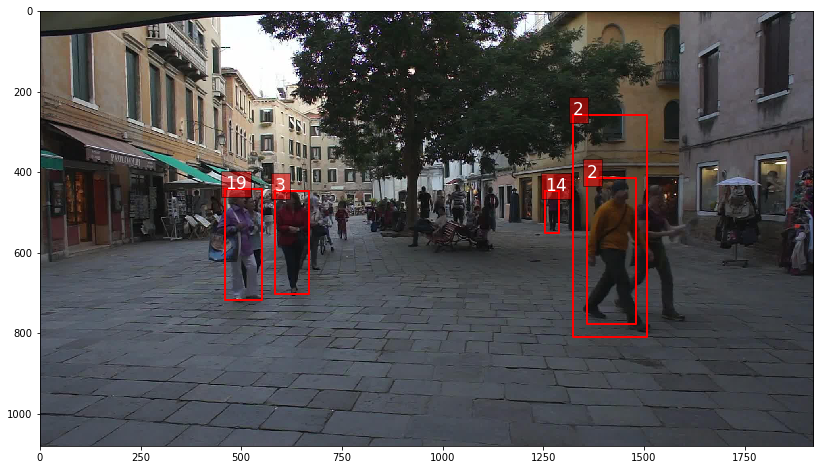

In [3]:
def get_gt_detections(frame):
    y_gt = get_visible_pedestrains(frame)
    y_det = get_visible_pedestrains_det(frame)
    true_detections = []
    for ped in y_det:
        i, _,l, t, w, h, score, _, _,_ = ped
        for ped_ in y_gt:
            j, pid, l_gt, t_gt, w_gt, h_gt, _, _, _ = ped_
            assert(i == j)
            if aabb.IoU((l,t,w,h), (l_gt,t_gt,w_gt,h_gt)) > 0.5:
                true_detections.append(
                    np.array([i, pid, l, t, w, h, score]))
    
    return true_detections

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(X[2])
TD = get_gt_detections(2)
for y in TD:
    f, pid, x, y, w, h, score = y
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=2, color='red')
    ax.text(x, y, str(int(pid)), color='white', fontsize=17,
                   bbox={'facecolor': 'red', 'alpha': 0.5})


(1359.0999999999999, 413.26999999999998, 120.26000000000001, 362.76999999999998) (1338.0, 418.0, 167.0, 379.0)
0.674235150086


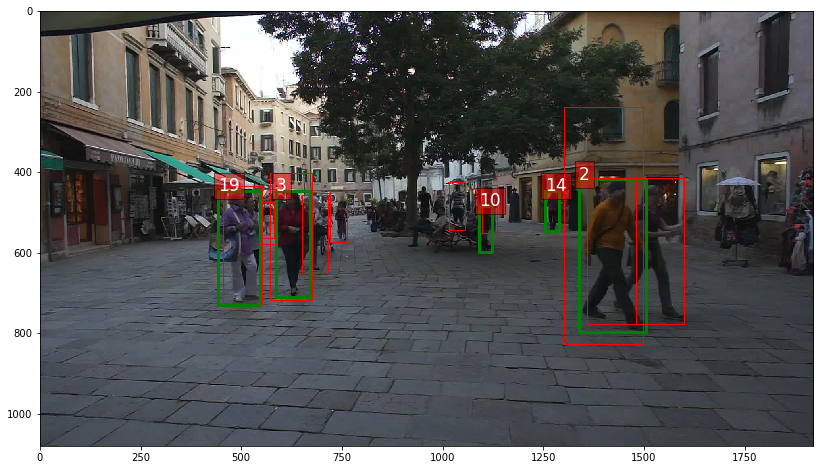

In [4]:
frame = 1

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(X[frame])

# ------------ GT ------------------
GT = MOT16.simplify_gt(Y_gt)
Y = utils.extract_eq(GT, col=0, value=frame)
for nbr, (_, pid, x, y, w, h) in enumerate(Y):
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=3, color='green')
    ax.text(x, y, str(int(pid)), color='white', fontsize=17,
                   bbox={'facecolor': 'red', 'alpha': 0.5})
    #ax.text(x+50, y, str(int(nbr)), color='white', fontsize=17,
    #               bbox={'facecolor': 'orange', 'alpha': 0.5})
# ----------------------------------

Y = utils.extract_eq(Y_det, col=0, value=frame)
for nbr, (_, _, x, y, w, h, score, _, _, _) in enumerate(Y):
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=1, color='red')
    #ax.text(x, y+h, str(int(nbr)), color='white', fontsize=17,
    #               bbox={'facecolor': 'blue', 'alpha': 0.5})
# ----------------------------------

V = Y[0]
W = GT[0]

A = (V[2], V[3], V[4], V[5])
B = (W[2], W[3], W[4], W[5])

print(A,B)
print(aabb.IoU(A,B))
    
plt.show()